<h3>Nueral Network Layout</h3>

We will be using a neural network approach to classify. The approach consists of severaal fully connected layers where the first is features, followed by some hidden layers and finally an output layer.
![nn_sample](https://www.qtravel.ai/wp-content/uploads/2023/07/sieci-neuronowe-grafika.png)



<h3>Libraries</h3>
In the following cell, we will import the libraries that are needed for the different parts of the code.

In [1]:
import torch                                           # for creating and training neural networks  
import torch.nn as nn                                  # for creating neural networks
import torch.nn.functional as F                        # for using activation functions 
import matplotlib.pyplot as plt                        # for plotting
import pandas as pd                                    # for dealing with dataframes
import numpy as np                                     # to allow using numpy arrays below
from sklearn.model_selection import train_test_split   # to allow splitting, training and testing
from scipy.stats import ttest_ind                      # to allow t-testing
from sklearn.model_selection import KFold              # to allow k-fold cross validation

<h3>Helper Functions</h3>
In this section, we will define some functions that are going to be used below for different purposes such as filteration, and plotting.

In [7]:
# ------------------------------    Calculating p-values    ------------------------------

def t_test(df, threshold=0.05):
    # Define the flare categories
    group_1 = df[df['Flare'] == 1].drop('Flare', axis=1)  # All samples where flare = 1
    group_3 = df[df['Flare'] == 0].drop('Flare', axis=1)  # All samples where flare = 3

    # Dictionary to store p-values for each gene
    p_values = {}

    # Loop over each gene (column) and perform the statistical test
    for gene in group_1.columns:
        # Extract the gene expression data for each group
        group_1_data = group_1[gene]
        group_3_data = group_3[gene]
        
        # Perform a t-test (you can also use mannwhitneyu for non-parametric test)
        t_stat, p_val = ttest_ind(group_1_data, group_3_data, equal_var=False)  # Welch's t-test
        
        # Store the p-value
        p_values[gene] = p_val

    # Convert the results into a DataFrame for easier visualization
    p_values_df = pd.DataFrame(list(p_values.items()), columns=['Gene', 'P-value'])
    p_values_df = p_values_df.sort_values(by='P-value')
    # Display the p-values
    #print(p_values_df)

    # Drop the ones below 0.05 and save the gene names in a list
    significant_genes = p_values_df[p_values_df['P-value'] < threshold]['Gene'].tolist()
    
    # Debugging lines
    print("T-Test called")
    print("Significant genes length:", len(significant_genes))
    
    return p_values_df, significant_genes

# ------------------------------    Plotting     ------------------------------
def plot_loss(losses, epochs):
    '''
        This function plots the loss rate for each epoch.
        The loss rate is calculated during the training of the neural network.
    '''
    plt.plot(range(epochs),losses)
    plt.ylabel("Loss Rate")
    plt.xlabel("Epoch")

# ------------------------------    Filtering Genes     ------------------------------
def filter_genes(p_values_df, threshold=0.05):
    '''
        This function filters the genes based on the p-values.
        The genes with p-values below the threshold are selected.
        The function returns the filtered genes.
    '''
    #print("function called")
    significant_genes = p_values_df[p_values_df['P-value'] < threshold]['Gene'].tolist()
    return significant_genes

# ------------------------------    Old Filtering Function     ------------------------------
def selected_sample(filtering_set, original_data, number_of_ids):
    selected_IDs = filtering_set["GeneID"][0:number_of_ids].tolist()
    selected_IDs.append("Flare")
    return original_data[selected_IDs] 


# ------------------------------    Cross Validation    ------------------------------

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import KFold

def cross_validation(data, epochs, batch_size=10, learning_rate=2e-4, threshold=0.05, k=5, patience=100):
    '''
    This function performs the cross-validation
    for the neural network model with early stopping.
    '''
    # Split the data into features and labels
    X = data.drop('Flare', axis=1).values
    y = data['Flare'].values    

    # Initialize KFold
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # Define the list to store the accuracies
    accuracies = []

    # Loop over each fold
    for fold, (train_index, val_index) in enumerate(kf.split(X)):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Create a dataframe that has X_train and y_train
        train_data = pd.DataFrame(X_train)
        train_data["Flare"] = y_train

        # Perform the t-test to get the p-values
        p_values_df, significant_genes = t_test(train_data, threshold)

        # Filter the genes based on the p-values
        X_train = train_data[significant_genes].values
        X_val = pd.DataFrame(X_val)[significant_genes].values

        # Convert the data into PyTorch tensors
        X_train = torch.FloatTensor(X_train)
        X_val = torch.FloatTensor(X_val)
        y_train = torch.LongTensor(y_train)
        y_val = torch.LongTensor(y_val)

        # Create a model
        model = Model(in_features=X_train.shape[1])

        # Define the loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # Early stopping variables
        best_loss = float('inf')
        patience_counter = 0

        # Lists to store loss values
        train_losses = []
        val_losses = []

        # Train the model
        model.train()
        early_stopped_epoch = -1  # To keep track of when early stopping happens
        for epoch in range(epochs):
            optimizer.zero_grad()
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
            loss.backward()
            optimizer.step()

            # Store the training loss
            train_losses.append(loss.item())

            # Validate the model
            model.eval()
            with torch.no_grad():
                y_pred_val = model(X_val)
                val_loss = criterion(y_pred_val, y_val)
                val_losses.append(val_loss.item())

            # Check for early stopping
            if val_loss < best_loss:
                best_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch + 1}')
                early_stopped_epoch = epoch  # Record the epoch where early stopping occurred
                break

        # If early stopping occurred, simulate the remaining epochs for plotting
        if early_stopped_epoch != -1:
            # Pad the losses with the last loss value to simulate continuation for the plot
            train_losses.extend([train_losses[-1]] * (epochs - early_stopped_epoch - 1))
            val_losses.extend([val_losses[-1]] * (epochs - early_stopped_epoch - 1))

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            y_pred = model(X_val)
            correct = (y_pred.argmax(1) == y_val).type(torch.float).sum().item()
            accuracy = correct / len(y_val)
            accuracies.append(accuracy)
            # Show the accuracy for each fold
            print(f'Fold {fold + 1}/{k} Accuracy: {accuracy}')

        # Plot the training and validation loss
        plt.figure()
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')

        # Show a vertical line at the early stopping point if it occurred
        if early_stopped_epoch != -1:
            plt.axvline(x=early_stopped_epoch, color='r', linestyle='--', label=f'Early Stopping at Epoch {early_stopped_epoch + 1}')

        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Fold {fold + 1} Loss')
        plt.legend()
        plt.show()

    # Calculate the average accuracy
    average_accuracy = sum(accuracies) / k

    return average_accuracy


<h3>Defining the Neural Network Model</h3>
In the following section we will define the NN model to be used for training.

In [8]:
#number_of_features = 1250
number_of_neurons = 512
class Model(nn.Module):
    ''' Creating input layers that will have the features of the data.
    This will be sent to hidden layers to learn and finally this will 
    produce the classification as the output.'''
    number_of_outcomes = 2  # Possible outcomes

    
    def __init__(self, in_features, h1=2048, h2=2048, h3=2048, h4=1024, h5=512, h6=256, h7=128, h8=64, out_features=number_of_outcomes):
        # Calling the constructor of the superclass to instantiate nn.Module
        super().__init__()
        
        # Define the layers
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.fc4 = nn.Linear(h3, h4)
        self.fc5 = nn.Linear(h4, h5)
        self.fc6 = nn.Linear(h5, h6)
        self.fc7 = nn.Linear(h6, h7)
        self.fc8 = nn.Linear(h7, h8)
        self.out = nn.Linear(h8, out_features)

    # Function that moves everything forward in the layers
    def forward(self, x):
        # Rectified linear unit function that will only use positive output and set negatives to zero
        x = F.relu(self.fc1(x))  # Starting with layer 1
        x = F.relu(self.fc2(x))  # Moving to layer 2
        x = F.relu(self.fc3(x))  # Moving to layer 3
        x = F.relu(self.fc4(x))  # Moving to layer 4
        x = F.relu(self.fc5(x))  # Moving to layer 5
        x = F.relu(self.fc6(x))  # Moving to layer 6
        x = F.relu(self.fc7(x))  # Moving to layer 7
        x = F.relu(self.fc8(x))  # Moving to layer 8
        x = self.out(x)
        return x  # Returning the output

<h3>Loading and Preparing the Data</h3>
In the following cell, we will load the data to be used for training the model. In this case, it is the filtered flare data in which only week 48 samples are selected. The data is also cleaned to remove any genes with constant expression number and/or very low expression number. The next step is to make sure the data is ready to be used for the prediction.


In [9]:
all_data = pd.read_csv('processed_data.csv')

# replace Flare 3 with 0 to make it binary classification
all_data['Flare'] = all_data['Flare'].replace(3, 0)

<h3>Running the Model</h3>
Next, we will run the model using the functions defined above.

T-Test called
Significant genes length: 741
Early stopping at epoch 163
Fold 1/10 Accuracy: 0.6666666666666666


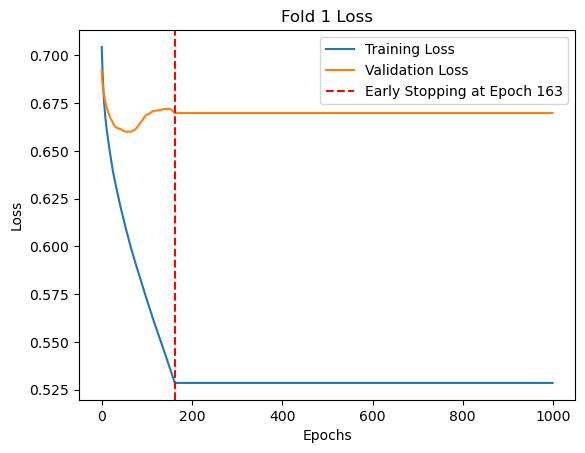

T-Test called
Significant genes length: 753
Early stopping at epoch 235
Fold 2/10 Accuracy: 0.6111111111111112


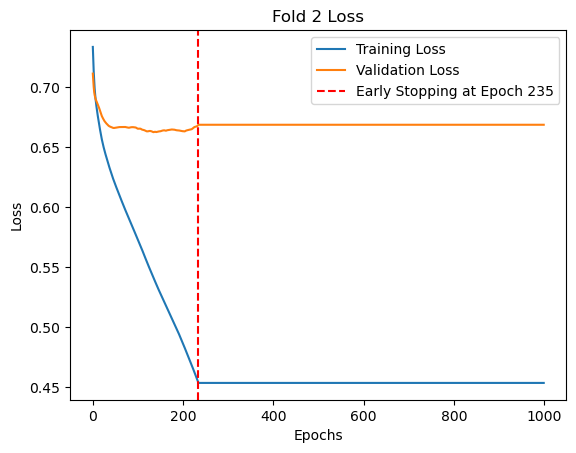

T-Test called
Significant genes length: 886
Early stopping at epoch 111
Fold 3/10 Accuracy: 0.3888888888888889


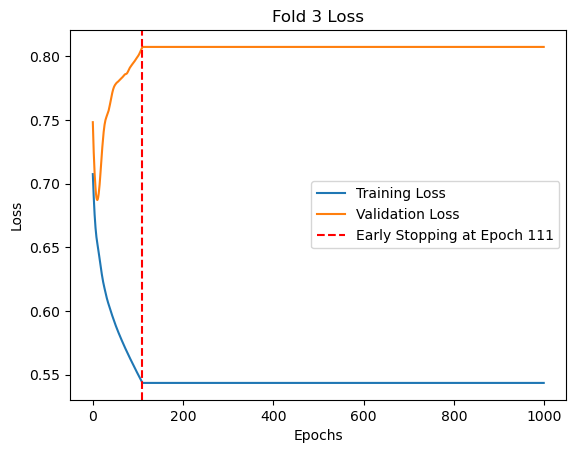

T-Test called
Significant genes length: 606
Early stopping at epoch 129
Fold 4/10 Accuracy: 0.6111111111111112


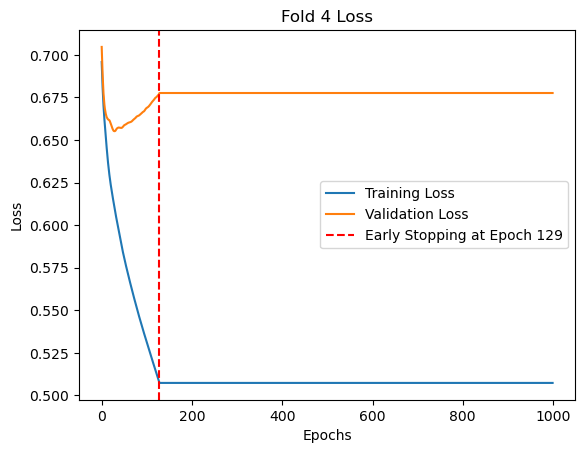

T-Test called
Significant genes length: 986
Early stopping at epoch 121
Fold 5/10 Accuracy: 0.6470588235294118


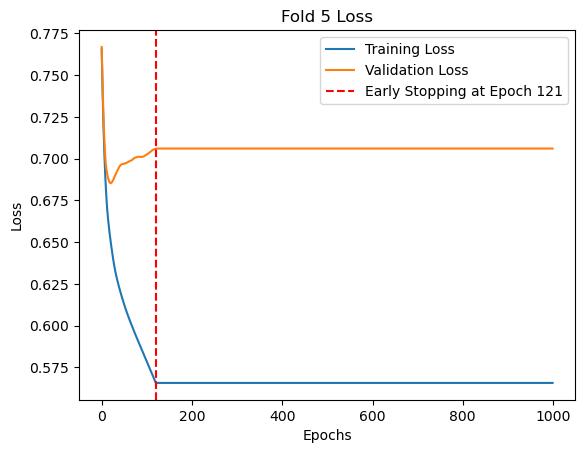

T-Test called
Significant genes length: 771
Early stopping at epoch 660
Fold 6/10 Accuracy: 0.7647058823529411


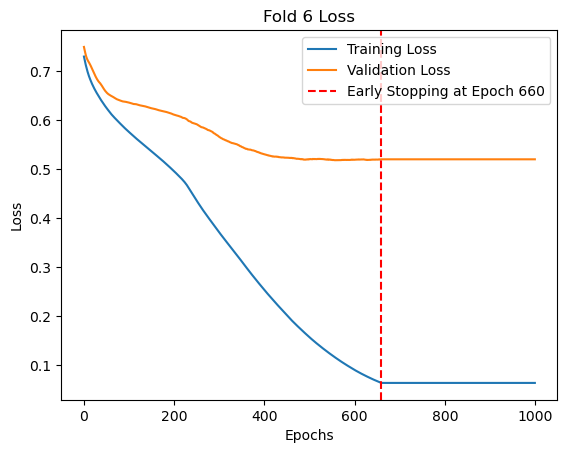

T-Test called
Significant genes length: 607
Early stopping at epoch 341
Fold 7/10 Accuracy: 0.5882352941176471


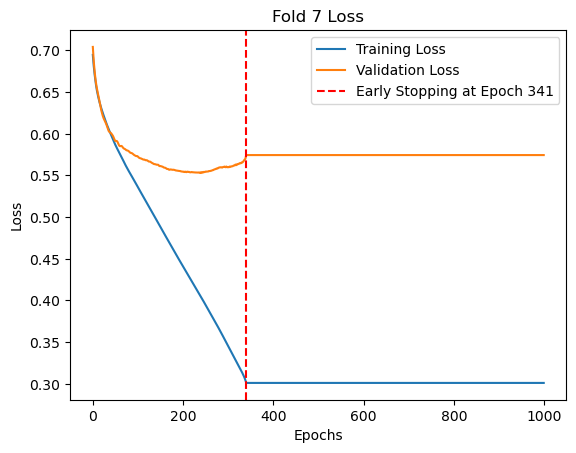

T-Test called
Significant genes length: 813
Early stopping at epoch 202
Fold 8/10 Accuracy: 0.6470588235294118


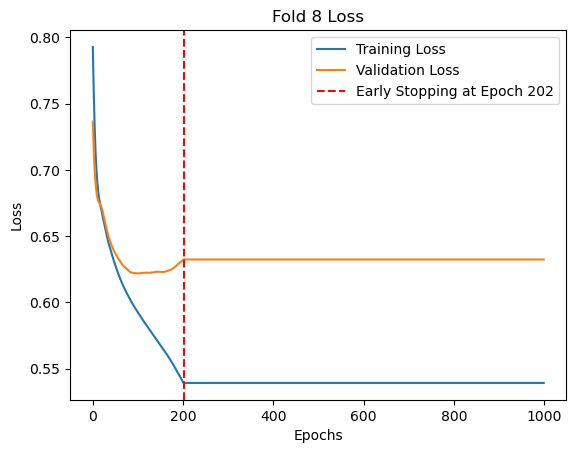

T-Test called
Significant genes length: 996
Early stopping at epoch 112
Fold 9/10 Accuracy: 0.7647058823529411


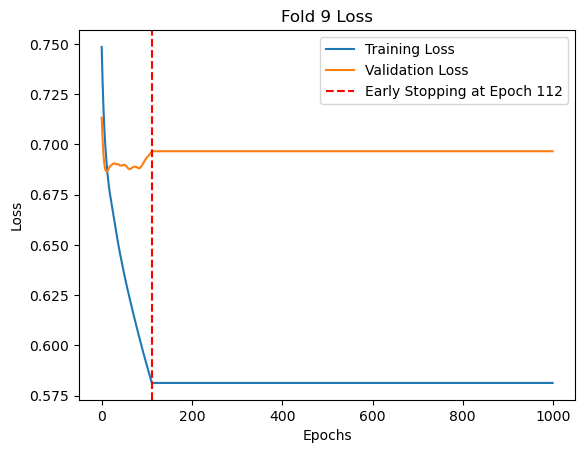

T-Test called
Significant genes length: 706
Early stopping at epoch 248
Fold 10/10 Accuracy: 0.5882352941176471


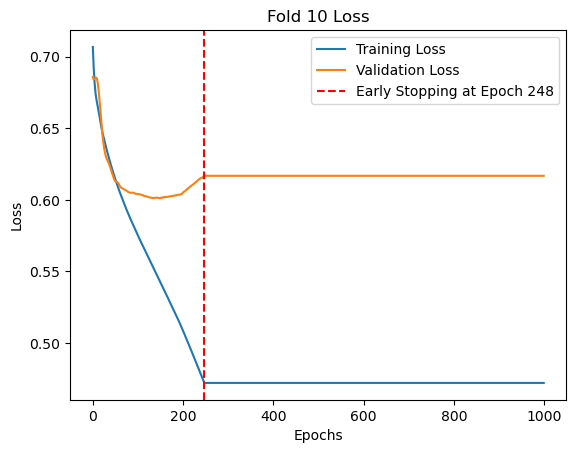

Average accuracy: 0.6277777777777778


In [10]:
# create a model
#model = Model()

# define the number of epochs
epochs = 1000 # was 3500

# define the batch size
batch_size = 32 # 10

# define the learning rate
learning_rate = 1e-6 # was 2e-4

# define the threshold for the p-values
threshold = 0.05 # was 0.05

# define the number of folds for cross-validation
k = 10 # was 10

# define the patience for early stopping
patience= 50 # was 100

# Perform cross-validation
average_accuracy = cross_validation(all_data, epochs, batch_size, learning_rate, threshold, k)
print(f'Average accuracy: {average_accuracy}')


In [62]:
# Calculate the p-values
p_values_df, significant_genes = t_test(all_data, threshold=0.05)
print("Significant gene count: ", len(significant_genes))
# Creating a new dataframe with the significant genes
selected_data = all_data[significant_genes + ['Flare']]

# dimensions of the data
print(selected_data.shape)

# Train and test the neural network

#accuracy, losses = train_and_test(selected_data, significant_genes, epochs=100, lr=0.01)    


                  Gene   P-value
2119   ENSG00000101447  0.000211
20156  ENSG00000259121  0.000322
23520  ENSG00000277911  0.000553
712    ENSG00000063180  0.000650
24857  ENSG00000285935  0.000709
...                ...       ...
26702  ENSG00000290241       NaN
26703  ENSG00000290525       NaN
26704  ENSG00000291014       NaN
26705  ENSG00000291157       NaN
26706  ENSG00000291288       NaN

[26707 rows x 2 columns]
T-Test called
Significant genes lenght: 786
Significant gene count:  786
(174, 787)


<h3>Defining the Neural Network Model</h3>
The next cell defines a basic nueral network model that will be used for training

In [ ]:
'''
p-value
random_state_number = 42
number_of_features = 1250
iterations = 3500
learning_rate = 2e-4
testing_size  = 0.20
number_of_neurons = 15    ==> 77.14285714285715%
'''

# Setting the model variables outside the class to allow tweaking
# These are the hyperparameters that can be changed to improve the model

random_state_number = 42
number_of_features = 1250
iterations = 3500
learning_rate = 2e-4
testing_size  = 0.20
number_of_neurons = 15
# Creating a model class inheriting the nn module
class Model(nn.Module):
    ''' creating input layers that will have the fetures of the data
     this will be sent to hidden layers to learn and finally this will 
     produce the classification as the output'''
    # the number of features depend on the dataset, in this example we only have 4
    # h1 and h2 are hidden layers and the numbers are number of neurons which are 
    # arbitrary for now. Out fetures is set to 3 as we have three classes in the model
    #number_of_features = 1500#26707 # Number of gene IDs
    number_of_outcomes = 2     # Possible outcomes

    
    def __init__(self, in_features = number_of_features, h1 = number_of_neurons , h2 = number_of_neurons, out_features = number_of_outcomes):
        # calling the constructor of the superclass to instantiate nn.Module
        super().__init__()
        
        # fc1 = fully connected layer 1
        # we are moving the data between the layers
        self.fc1 = nn.Linear(in_features , h1)
        self.fc2 = nn.Linear(h1 , h2)
        self.out = nn.Linear(h2 , out_features)

# need to create a function that moves everything forward in the layers
    def forward(self, x):
        # rectified linear unit function that will only use positive output and set negatives to zero
        x = F.relu(self.fc1(x)) # starting with layer 1
        x = F.relu(self.fc2(x)) # moving to layer 2
        x = self.out(x)         # moving to the output layer

        return x                # returning the output
    

Since neural networks rely on randomization, we will need to create a seed to allow regenerating the output. The number used here can be any number nut it will help us to regenerate  the output if we needed to.

In [3]:
torch.manual_seed(random_state_number) # can be any number
# Creating an instance of out model to turn on the code above
model = Model()

<h4>Loading the Data and Training the Model</h4>

Now that our model is created, we can load the data and train the model on the data that we have

In [ ]:


    
# creating a url to load the data from the iris dataset
#data_url = "provide csv file's url here"
                    # replace this with url if importing one online

'''
    This is where we can change the dataset to train on a different data
'''
# Loading sorted gene ids:
p_value_sorted = pd.read_csv("p_value_data.csv")
log2fc_sorted = pd.read_csv("log2fc_data.csv")

#loading all data
all_data = pd.read_csv('processed_data.csv')   
my_df = selected_sample(filtering_set = p_value_sorted, original_data = all_data, number_of_ids = number_of_features)  
my_df.head(10)

,ENSG00000226571,ENSG00000230202,ENSG00000130202,ENSG00000286830,ENSG00000162383,ENSG00000167034,ENSG00000230021,ENSG00000232573,ENSG00000211804,ENSG00000132464,...,ENSG00000164707,ENSG00000143850,ENSG00000135211,ENSG00000211593,ENSG00000235194,ENSG00000228237,ENSG00000132196,ENSG00000168538,ENSG00000187953,Flare
0,7.326576,4.884384,29.306303,20.758632,74.486855,111.119734,81.813430,9.768768,2.442192,6.105480,...,155.079189,8.547672,56.170415,15.874248,289.399747,94.024390,95.245486,382.203041,65.939183,3
1,4.114614,9.875074,28.802300,3.291691,9.875074,17.281380,35.385683,22.218917,31.271068,4.937537,...,143.188576,12.343843,62.542137,32.916914,432.034497,82.292285,101.219511,497.868325,60.073368,1
2,12.747243,2.731552,59.183626,10.015691,32.778624,11.836725,37.331210,23.673451,10.015691,25.494485,...,231.271401,5.463104,39.152245,214.882089,390.611933,115.635701,103.798975,542.668327,89.230698,1
3,15.579733,14.714193,11.252030,6.924326,74.436504,10.386489,25.966222,21.638519,15.579733,16.445274,...,161.856120,5.193244,64.915556,55.394608,442.291323,90.881779,129.831112,420.652804,92.612860,1
4,9.880258,8.468792,103.036975,50.812755,8.468792,19.760516,47.989824,15.526120,7.057327,2.822931,...,193.370762,15.526120,52.224220,15.526120,389.564454,86.099390,93.156717,405.090574,46.578359,1
5,13.139760,1.194524,20.306902,15.528807,8.361665,13.139760,58.531658,20.306902,3.583571,14.334284,...,143.342835,7.167142,50.169992,23.890473,401.359938,81.227607,112.285221,536.341108,66.893323,3
6,10.507277,10.507277,37.359206,5.837376,15.177177,15.177177,50.201433,18.679603,10.507277,5.837376,...,145.934399,12.842227,50.201433,46.699008,456.482800,108.575193,110.910143,505.516758,68.881036,3
7,28.912215,181.449072,32.900106,7.975783,194.409720,3.987892,42.869836,16.948540,2.990919,9.969729,...,125.618588,13.957621,50.845619,10.966702,431.689276,118.639778,114.651886,482.534895,58.821402,1
8,15.932509,11.683840,41.424523,35.051520,5.310836,12.746007,45.673192,11.683840,4.248669,3.186502,...,227.303793,7.435171,44.611025,9.559505,421.680402,88.159882,129.584406,502.405113,60.543534,1
9,22.725222,6.197788,48.549338,23.758186,19.626328,16.527434,48.549338,11.362611,14.461505,85.736064,...,150.812836,20.659293,32.021904,26.857080,506.152669,85.736064,146.680978,423.515498,68.175666,3


To avoid any potential problems with data, we will encode the species column into numerical values as most machine learning approaches work better with numerical values. These values could then be encoded back to any class names that we need.

In [ ]:
# avoids downcasting warning as we are downcasting from an object (string) to a primitive data type
# May need to use this based on flare numbers but not for now

pd.set_option('future.no_silent_downcasting', True) 

my_df['Flare'] = my_df['Flare'].replace(3,0) # changing the flare 3 to 0 to make it binary
my_df.head(10)



/var/folders/60/jkn0_02s1lv9xfxqt4gzj2lw0000gn/T/ipykernel_58725/2233537459.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_df['Flare'] = my_df['Flare'].replace(3,0)


,ENSG00000226571,ENSG00000230202,ENSG00000130202,ENSG00000286830,ENSG00000162383,ENSG00000167034,ENSG00000230021,ENSG00000232573,ENSG00000211804,ENSG00000132464,...,ENSG00000164707,ENSG00000143850,ENSG00000135211,ENSG00000211593,ENSG00000235194,ENSG00000228237,ENSG00000132196,ENSG00000168538,ENSG00000187953,Flare
0,7.326576,4.884384,29.306303,20.758632,74.486855,111.119734,81.813430,9.768768,2.442192,6.105480,...,155.079189,8.547672,56.170415,15.874248,289.399747,94.024390,95.245486,382.203041,65.939183,0
1,4.114614,9.875074,28.802300,3.291691,9.875074,17.281380,35.385683,22.218917,31.271068,4.937537,...,143.188576,12.343843,62.542137,32.916914,432.034497,82.292285,101.219511,497.868325,60.073368,1
2,12.747243,2.731552,59.183626,10.015691,32.778624,11.836725,37.331210,23.673451,10.015691,25.494485,...,231.271401,5.463104,39.152245,214.882089,390.611933,115.635701,103.798975,542.668327,89.230698,1
3,15.579733,14.714193,11.252030,6.924326,74.436504,10.386489,25.966222,21.638519,15.579733,16.445274,...,161.856120,5.193244,64.915556,55.394608,442.291323,90.881779,129.831112,420.652804,92.612860,1
4,9.880258,8.468792,103.036975,50.812755,8.468792,19.760516,47.989824,15.526120,7.057327,2.822931,...,193.370762,15.526120,52.224220,15.526120,389.564454,86.099390,93.156717,405.090574,46.578359,1
5,13.139760,1.194524,20.306902,15.528807,8.361665,13.139760,58.531658,20.306902,3.583571,14.334284,...,143.342835,7.167142,50.169992,23.890473,401.359938,81.227607,112.285221,536.341108,66.893323,0
6,10.507277,10.507277,37.359206,5.837376,15.177177,15.177177,50.201433,18.679603,10.507277,5.837376,...,145.934399,12.842227,50.201433,46.699008,456.482800,108.575193,110.910143,505.516758,68.881036,0
7,28.912215,181.449072,32.900106,7.975783,194.409720,3.987892,42.869836,16.948540,2.990919,9.969729,...,125.618588,13.957621,50.845619,10.966702,431.689276,118.639778,114.651886,482.534895,58.821402,1
8,15.932509,11.683840,41.424523,35.051520,5.310836,12.746007,45.673192,11.683840,4.248669,3.186502,...,227.303793,7.435171,44.611025,9.559505,421.680402,88.159882,129.584406,502.405113,60.543534,1
9,22.725222,6.197788,48.549338,23.758186,19.626328,16.527434,48.549338,11.362611,14.461505,85.736064,...,150.812836,20.659293,32.021904,26.857080,506.152669,85.736064,146.680978,423.515498,68.175666,0


<h3>Train, Test, and Split</h3>
Now we want to split our dataset and train our model so that it can be able to classify new entires into one of the three classes based on the features that we get.

First, we need to saxe the features on one side and the classification on another side. We will save all features in a variable called X and the classification or outcome in a variable called y. Having the X as uppercase and y as lowercase is just the codeing convention for such problems but it does not really matter if we made both uppercase or both lowercase.  

In [6]:
# X will ahve geneIDs and y will have flare/no flare
X = my_df.drop('Flare', axis = 1).values # axis = 1 since it is a column
y = my_df['Flare'].values

# training, testing and splitting
# using 80% of the data for training and 20 for testing
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = testing_size, random_state = random_state_number) # last part is optional

<h4>Convert to Tensors</h4>
As pyTorch is all about tensors so we need the data to be converted to tensors

In [7]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train) # Using Long as these are 64 bit integers to match what we have above
y_test = torch.LongTensor(y_test)

<h4>Measuring Error</h4>
To check how far off the prediction is from the data

In [8]:
criterion = nn.CrossEntropyLoss()
'''
 Choosing an optimizer <- need to check later if there are better ones
 Setting the learning rate. If the error does not go down after a certain amount of 
 epochs then we need to lower this. Parameters here are fc1, fc2, and output.
'''
#torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) # the lower the rate = longer training time

# double checking the parameters:
model.parameters
# X_train had nan values so I replaced them with zeros for now
X_train = torch.nan_to_num(X_train, nan=0.0)
X_test = torch.nan_to_num(X_test, nan=0.0)


print("Checking X_train for NaNs or infinities:")
print(torch.isnan(X_train).sum())  # Should be 0 if no NaN values
print(torch.isinf(X_train).sum())  # Should be 0 if no infinite values


print("Checking y_train for NaNs or invalid values:")
print(torch.isnan(y_train).sum())  # Should be 0 if no NaN values
print(torch.isinf(y_train).sum())  # Should be 0 if no infinite values
print(torch.unique(y_train)) # Should be only [0, 1] for binary classification

Checking X_train for NaNs or infinities:
tensor(0)
tensor(0)
Checking y_train for NaNs or invalid values:
tensor(0)
tensor(0)
tensor([0, 1])


<h4>Training the Model</h4>
We need to set up the number of epochs. An epoch is one run through all of our training data. Basically running all the trainig data through the entire netweork. We also want to keep track of the loss which should decrease overtime to show that the model is learning. 

In [ ]:
epochs = iterations # we can change this to optimize the learining
losses = [] # to store loss overtime
for i in range(epochs):
    # trying to get predicted results by sending the training data through the network
    y_pred = model.forward(X_train)

    # Keeping track of the loss (error) using the predicted value vs the training value
    loss = criterion(y_pred, y_train)
    # saving losses in the list to have a history to show how well we are learning
    losses.append(loss.detach().numpy())

    # Print data to see what is going on -  we will print every 10 iterations
    if i%100 == 0:
        print(f"Epoch: {i} , Loss: {loss}")

    '''Do backporpagation to take the error rate moving forward and feed it back through the 
        network to fine tune the weights for the neural netweork '''
    
    ''' Clears the old gradients from the previous step: if you don't zero out the gradients after each step, 
    the gradients from the previous batch will be added to the gradients of the current batch, which 
    will mess up the training process.'''
    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

Epoch: 0 , Loss: 38.06991195678711
Epoch: 100 , Loss: 0.6973076462745667
Epoch: 200 , Loss: 0.40419405698776245
Epoch: 300 , Loss: 0.21730880439281464
Epoch: 400 , Loss: 0.13347841799259186
Epoch: 500 , Loss: 0.06971614807844162
Epoch: 600 , Loss: 0.04443449154496193
Epoch: 700 , Loss: 0.030710384249687195
Epoch: 800 , Loss: 0.022515200078487396
Epoch: 900 , Loss: 0.01700417883694172
Epoch: 1000 , Loss: 0.013295282609760761
Epoch: 1100 , Loss: 0.010653112083673477
Epoch: 1200 , Loss: 0.008699815720319748
Epoch: 1300 , Loss: 0.007215939927846193
Epoch: 1400 , Loss: 0.006054365076124668
Epoch: 1500 , Loss: 0.005150021519511938
Epoch: 1600 , Loss: 0.004424495156854391
Epoch: 1700 , Loss: 0.0038494772743433714
Epoch: 1800 , Loss: 0.003364274278283119
Epoch: 1900 , Loss: 0.002959681674838066
Epoch: 2000 , Loss: 0.0026197086554020643
Epoch: 2100 , Loss: 0.0023358671460300684
Epoch: 2200 , Loss: 0.002092033624649048
Epoch: 2300 , Loss: 0.00187613011803478
Epoch: 2400 , Loss: 0.001693467260338

Text(0.5, 0, 'Epoch')

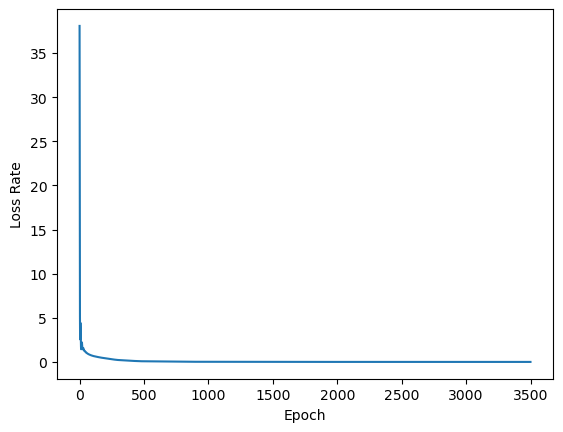

In [ ]:
# plotting to see how we are learning
plot_loss(losses, epochs)


<h4>Evaluate and Test</h4>
Here we will test the model to see if it was able to classify instances based on the model above.

In [11]:
with torch.no_grad(): # turning off backpropagation to send only through the model not back
    y_eval = model.forward(X_test) # X_test : features from our test set.
    loss = criterion(y_eval , y_test)
loss

tensor(1.5411)

In [12]:
correct = 0 
with torch.no_grad():
    for i, data in enumerate(X_test):
        y_val = model.forward(data)
        print(f'{i}. {y_val}, Test was: {y_test[i]}' )
        if y_val.argmax().item() == y_test[i]:
            correct+=1
print(f'Correct percentage:{correct/len(y_test) *100}%')

0. tensor([50.4762, 50.1435]), Test was: 1
1. tensor([31.4572, 46.6063]), Test was: 1
2. tensor([32.6209, 39.1444]), Test was: 1
3. tensor([63.4825, 61.8769]), Test was: 0
4. tensor([48.3202, 61.2973]), Test was: 0
5. tensor([30.0461, 50.8026]), Test was: 1
6. tensor([42.4878, 40.9524]), Test was: 0
7. tensor([47.4955, 53.4705]), Test was: 1
8. tensor([53.3802, 47.6242]), Test was: 1
9. tensor([46.3643, 47.7583]), Test was: 1
10. tensor([58.2325, 55.2453]), Test was: 0
11. tensor([40.3010, 37.4085]), Test was: 0
12. tensor([46.9971, 56.2067]), Test was: 1
13. tensor([42.8026, 40.3173]), Test was: 0
14. tensor([49.9207, 40.6282]), Test was: 0
15. tensor([46.9275, 45.4035]), Test was: 0
16. tensor([58.7323, 52.3646]), Test was: 0
17. tensor([42.7522, 47.1219]), Test was: 1
18. tensor([32.5131, 39.3951]), Test was: 0
19. tensor([35.9538, 52.5645]), Test was: 1
20. tensor([41.9028, 52.7625]), Test was: 1
21. tensor([51.8158, 42.0941]), Test was: 0
22. tensor([38.8291, 51.1175]), Test was: 

<h3>Feeding New Data</h3>
In the next section, we can feed new data into the model and try to make the model predict/classify the instance based on the features.

<h3>Saving the Neural Network Model</h3>

Now that or model is trained and tested, we can sace it to use it later on

In [13]:
#torch.save(model.state_dict(), 'gout_model_p_value.pt') # will save the weights and biases of the model into a dictionar

Now that our model is saved, we can load it as follows:


### new_model = Model()
new_model.load_state_dict(torch.load('iris_test_model.pt'))
new_model.eval()

### to use the model, we will use the new_model to predict/ classify instead of model